<a href="https://colab.research.google.com/github/Sagar401/FAI/blob/features/Assignment_3_Street_View_House_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [1]:
%matplotlib inline
!pip install openml # Uncomment to run in Google Colab
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import time

     |████████████████████████████████| 163kB 2.8MB/s 
  Created wheel for openml: filename=openml-0.10.2-cp36-none-any.whl size=190318 sha256=7034c575d3e63dcde32318396f994ef505e0277d2d5757a5216503ac81fcac98
  Stored in directory: /root/.cache/pip/wheels/71/ec/5f/aaad9e184680b0b8f1a02ff0ec640cace5adf5bff7bb0af1b4
  Created wheel for liac-arff: filename=liac_arff-2.4.0-cp36-none-any.whl size=13335 sha256=2305350c129fb52bfcb94b5102b373e3dc0b8f9923fdf719394c9eb97fd4c415
  Stored in directory: /root/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5203
Successfully built openml liac-arff


In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

In [0]:
# To save time, you can save the dataset to a Google drive, and load it quickly later
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "wb") as f:
    pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
    pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# (Uncomment to) Load SVHN dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "rb") as f:
    X = pickle.load(f)
    y = pickle.load(f)
    cats = pickle.load(f)
    attrs = pickle.load(f)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [6]:
print("Shape of image data X: ",X.shape)

Shape of image data X:  (99289, 3072)


In [7]:
print("Number of images : ",len(X))

Number of images :  99289


Each row in image data X is an image with a size of 32 x 32 x 3, 3 here is for red, green and blue.

### You can use the following function to plot the first 10 images to get a sense of the data.

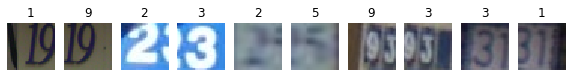

In [8]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

### Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

In [0]:
def rgb_to_grayscale(X):
  rgb_weights = [0.2989, 0.5870, 0.1140]
  grayscale_img = np.expand_dims(np.dot((X.reshape(len(X),32*32,3)/255 ),rgb_weights),axis=3)
  return grayscale_img


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


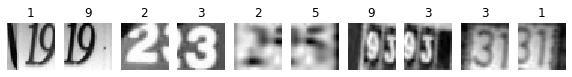

In [10]:
X_gray = rgb_to_grayscale(X)
plot_images(X_gray[0:10],y[0:10],True)

In [0]:
#here label for each image is set differently, so to maintain proper format adusting y(labels)
y = y +1
y = np.where(y == 10,0,y)

### Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

In [0]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

In [0]:
def evaluate_learners(classifiers, X, y):
  """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data. 

  Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
    - a list with the scores obtained on the training samples for each classifier,
    - a list with the test scores obtained on the test samples for each classifier.
    The order of scores should match the order in which the classifiers were originally provided. E.g.:     
    [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
  """
  results = [cross_validate(model,X,y, return_train_score=True,cv=3) for model in classifiers]
  test_scores = [r['test_score'] for r in results]
  train_scores = [r['train_score'] for r in results]
  return train_scores, test_scores


In [0]:
#defining all models in a list for executing in one go
classifiers = [LogisticRegression(),LinearSVC(),KNeighborsClassifier()]
classifiers = np.array([c for c in classifiers]).flatten()

#starting timer
startTime  = datetime.now()

#getting 1% from overall all data
X_sample, _ , y_sample, _ = train_test_split(X_gray,y,stratify = y,train_size = 0.01)
train_scores_1, test_scores_1 = evaluate_learners(classifiers,X_sample.reshape(len(X_sample),32*32),y_sample)

In [23]:
print("Time taken for execution: ", datetime.now()- startTime)

Time taken for execution:  0:00:35.775948


In [24]:
train_scores_1

[array([0.53857791, 0.53403933, 0.53021148]),
 array([0.81089259, 0.81089259, 0.78096677]),
 array([0.47352496, 0.48865356, 0.46676737])]

In [25]:
test_scores_1

[array([0.1570997 , 0.16918429, 0.16666667]),
 array([0.14501511, 0.16616314, 0.13636364]),
 array([0.25377644, 0.24471299, 0.26060606])]

**Analysis** : With such a small sample of dataset, models are expected to perform poorly. With our dataset it looks like training scores are around 80% for linear SVC but test scores are very poor thus showing strong overfitting and it's the same case for other two models as well.

Solution for this can be either increasing sample size or by tuning some hyper parameters.

In [0]:
#starting timer
startTime  = datetime.now()

# getting 3% of data for model evaulation
X_sample, _ , y_sample, _ = train_test_split(X_gray,y,stratify = y,train_size = 0.03)
train_scores_2, test_scores_2 = evaluate_learners(classifiers,X_sample.reshape(len(X_sample),32*32),y_sample)


In [27]:
print("Time taken for execution: ", datetime.now()- startTime)

Time taken for execution:  0:02:52.922803


In [30]:
train_scores_2

[array([0.35516373, 0.35667506, 0.3408862 ]),
 array([0.54055416, 0.5697733 , 0.47129909]),
 array([0.52745592, 0.51687657, 0.51913394])]

In [29]:
test_scores_2

[array([0.20644512, 0.20946626, 0.2016129 ]),
 array([0.18026183, 0.19939577, 0.16532258]),
 array([0.29707956, 0.30312185, 0.30745968])]

**Analysis** : With a slight increase in sample data we can see a slight improvement in test scores and training scores have decreased thus resulting in underfitting.

Solution for this is to increase sample size by a huge number and tuning some hyperparameters

### Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9,10],rotation=90)
  plt.yticks([])
  thisplot = plt.bar([0,1,2,3,4,5,6,7,8,9,10], predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [32]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.1.0


In [0]:
#spliting data into 80:20 ratio 
X_train, X_test , y_train, y_test = train_test_split(X_gray.reshape(len(X_gray),32,32),y,stratify = y,train_size = 0.8)

In [0]:
#defining model architecture, i.e with 1 hidden layer and 256 nodes in that layer
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,32)),
    keras.layers.Dense(256,activation = 'relu'),
    keras.layers.Dense(11)
])


In [0]:
#defining loss function 
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [37]:
#training model
model.fit(X_train, y_train, epochs=10)

Train on 79431 samples
Epoch 1/10
79431/79431 [==============================] - 9s 119us/sample - loss: 2.0714 - accuracy: 0.2548
Epoch 2/10
79431/79431 [==============================] - 8s 95us/sample - loss: 1.6864 - accuracy: 0.4148
Epoch 3/10
79431/79431 [==============================] - 7s 94us/sample - loss: 1.5272 - accuracy: 0.4895
Epoch 4/10
79431/79431 [==============================] - 7s 94us/sample - loss: 1.4416 - accuracy: 0.5305
Epoch 5/10
79431/79431 [==============================] - 8s 95us/sample - loss: 1.3954 - accuracy: 0.5493
Epoch 6/10
79431/79431 [==============================] - 7s 94us/sample - loss: 1.3754 - accuracy: 0.5560
Epoch 7/10
79431/79431 [==============================] - 8s 95us/sample - loss: 1.3528 - accuracy: 0.5671
Epoch 8/10
79431/79431 [==============================] - 7s 94us/sample - loss: 1.3412 - accuracy: 0.5725
Epoch 9/10
79431/79431 [==============================] - 8s 94us/sample - loss: 1.3269 - accuracy: 0.5778
Epoch 10/10
7

In [38]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

19858/19858 - 2s - loss: 1.2936 - accuracy: 0.5880

Test accuracy: 0.5879746


Model is underfitting as accuracy are very low, the reason is the way we have defined our architecture with 1 hidden layer and with 256 nodes within that hidden layer.
It is performing as poor as our previous linear models.

Solution for this is to redesign our neural architecture and add regularization and drop out for better results

In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
class_predictions = model.predict_classes(X_test)
prediction_probabilities = probability_model.predict(X_test)

In [0]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=class_predictions).numpy()

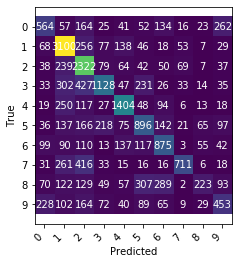

In [44]:
class_names = ['0','1','2','3','4','5','6','7','8','9']

fig, ax = plt.subplots()
im = ax.imshow(con_mat)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

for i in range(100):
    ax.text(int(i/10),i%10,con_mat[i%10,int(i/10)], ha="center", va="center", color="w")

**Analysis**  : '1' and '2' are highly classified wrong with some other number category. 

### Ploting correctly classified labels

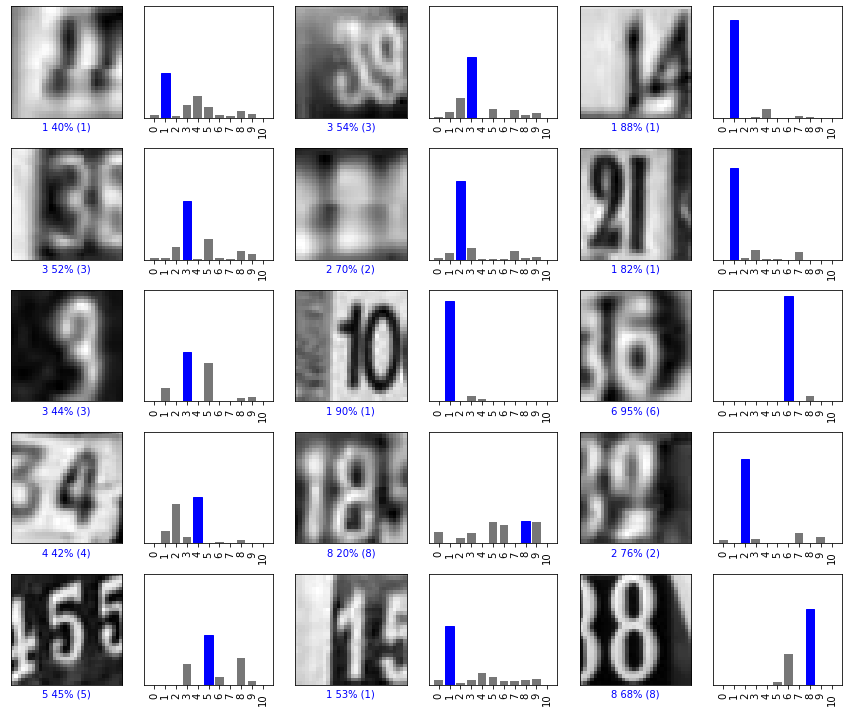

In [43]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
correctly_classified = np.where(class_predictions == y_test)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,j in zip(correctly_classified[0], range(num_images)):
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(i, prediction_probabilities[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(i, prediction_probabilities[i], y_test)
plt.tight_layout()
plt.show()

### Ploting incorrectly classified labels

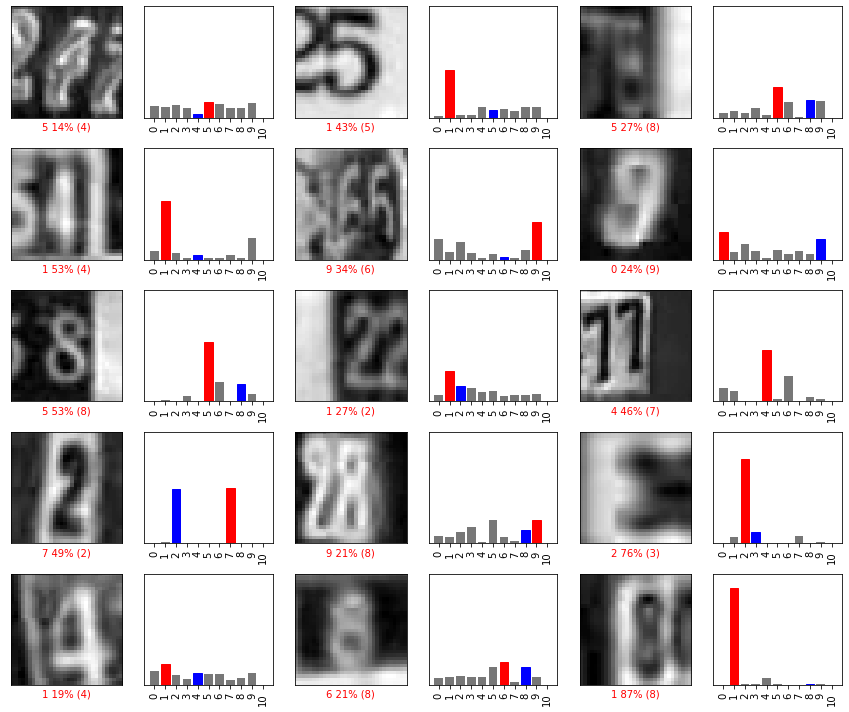

In [0]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
misclassified = np.where(class_predictions != y_test)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,j in zip(misclassified[0], range(num_images)):
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(i, prediction_probabilities[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(i, prediction_probabilities[i], y_test)
plt.tight_layout()
plt.show()

**Analysis** : From the first 15 misclassified set, 1 and 5 are mostly misclassified as some other number category. 

Bonus challenge: 
Can you improve the model performance from this first Keras model?
If you wonder about how researchers get to 98% accuracy, here is a list of papers :)
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e 